# PREVISÃO DA VELOCIDADE DO VENTO A CURTO PRAZO USANDO REDES NEURAIS ARTIFICIAIS EM MUCURI, BAHIA

## Configuração

Realizando imports necessários.

In [1]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tabulate
import tensorflow as tf

from datetime import datetime
from IPython.display import SVG, HTML, display
from keras import backend as K
from keras.callbacks import LambdaCallback, ModelCheckpoint
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import model_to_dot
from keras_lr_finder import LRFinder
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


Definição do modelo. 

In [2]:
class MucuriModel:
    def __init__(self, lr=0.01):

        self.model = None
        self.best_loss = 1e9

        self._build_model(lr)

    def _build_model(self, lr):

        if self.model is None:
            self.model = Sequential()
            self.model.add(Dense(9, input_shape=(9,)))
            self.model.add(Dense(9, activation="tanh"))
            self.model.add(Dense(6, activation="tanh"))
            self.model.add(Dense(1, activation="linear"))
            self.model.compile(
                loss="mean_squared_error",
                optimizer=RMSprop(lr=lr), #Adam(lr=0.1),
                metrics=["mse", "mae"],
            )

    def train(self, X, Y, X_test=None, Y_test=None, epochs=65, verbose=0):

        assert self.model is not None

        checkpoint_callback = ModelCheckpoint(
            filepath="./weights.hdf5", save_best_only=True, monitor="mse"
        )
        
        return self.model.fit(
            X,
            Y,
            validation_data=(X_test, Y_test)
            if X_test is not None and Y_test is not None
            else None,
            verbose=verbose,
            epochs=epochs,
            callbacks=[checkpoint_callback],
        )

    def predict(self, data):

        assert self.model is not None

        return self.model.predict(data)     

Foi utilizada a configuração 5 para a construção desse modelo, conforme especificado no paper. A quantidade de épocas foi definida por padrão como 65, no entanto essa quantidade pode ser ajustada. A função de loss foi definida como a de `mean squared error` e as métricas MSE, MAE e r2 são usadas para a avaliação da performance. O otimizador RMSprop foi utilizado, configurado com o `learning rate` padrão de 0.01.

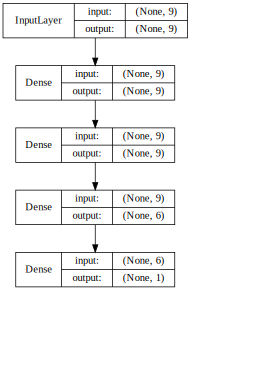

In [3]:
model = MucuriModel(lr=0.01)

SVG(model_to_dot(model.model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

## Leitura e normalização dos dados

Lendo o arquivo que contém os dados a serem analisados.

In [4]:
_file = pd.ExcelFile("./Mucuri_novo_semNaN_torre150m.xlsx")
df = _file.parse("Dados anemo")

Carregando os dados de treino e teste, ordenando as colunas da seguinte maneira:

> pressão, umid, temp, dir_1, v_anemo2, hora, ano, mês, dia

As informações referentes às datas (i.e. ano, mês e dia) foram colocadas por último, já que a sua repetição na massa de dados dificulta a convergência do modelo.

In [5]:
train_data_1 = df[pd.to_datetime(df["Data"]) <= datetime(year=2015, month=12, day=22)]
train_data_2 = df[
    (pd.to_datetime(df["Data"]) == datetime(year=2015, month=12, day=23))
    & (df["hora"] <= 11)
]

X_train_data = pd.concat([train_data_1, train_data_2]).drop("Data", axis=1)

cols = X_train_data.columns.tolist()
cols = cols[::-1]

X_train_data = X_train_data[cols]

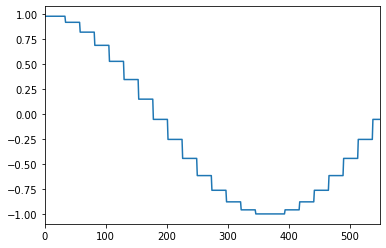

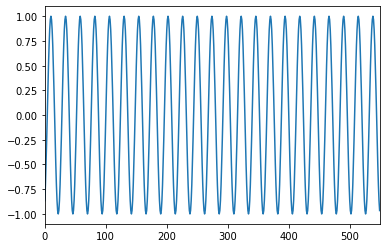

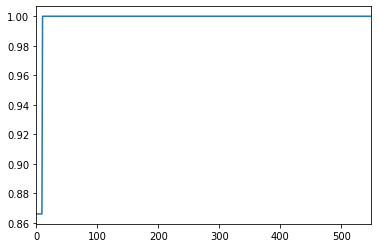

,pressão,umid,temp,dir_1,v_anemo2,ano,mês_cos,dia_cos,hora_cos
0,1020.422601,72.930636,27.516129,75.105481,13.012139,2015,0.866025,0.979530,-8.660254e-01
1,1020.394348,75.212121,27.238095,68.334332,12.726087,2015,0.866025,0.979530,-7.071068e-01
2,1020.508333,75.741379,27.105263,64.457865,12.081111,2015,0.866025,0.979530,-5.000000e-01
3,1020.611000,75.302632,26.305556,53.842100,11.647222,2015,0.866025,0.979530,-2.588190e-01
4,1020.866500,76.592593,25.464286,53.945279,11.064444,2015,0.866025,0.979530,-1.836970e-16
...,...,...,...,...,...,...,...,...,...
545,1015.316167,86.600000,22.637795,67.426924,2.912222,2015,1.000000,-0.050649,-2.588190e-01
546,1015.975667,82.110390,22.455696,84.999251,3.958333,2015,1.000000,-0.050649,-5.000000e-01
547,1016.323667,79.801205,22.602410,107.133454,5.216667,2015,1.000000,-0.050649,-7.071068e-01
548,1016.071500,80.907407,22.203252,110.979895,6.506667,2015,1.000000,-0.050649,-8.660254e-01


In [6]:
X_train_data["mês_cos"] = np.cos(2 * np.pi * X_train_data["mês"] / 12)
X_train_data["dia_cos"] = np.cos(2 * np.pi * X_train_data["dia"] / 31)
X_train_data["hora_cos"] = np.cos(2 * np.pi * X_train_data["hora"] / 24)

X_train_data.drop("dia", axis=1, inplace=True)
X_train_data.drop("hora", axis=1, inplace=True)
X_train_data.drop("mês", axis=1, inplace=True)

X_train_data["dia_cos"].plot()
plt.show()
X_train_data["hora_cos"].plot()
plt.show()
X_train_data["mês_cos"].plot()
plt.show()
X_train_data

In [7]:
test_data_1 = df[
    (pd.to_datetime(df["Data"]) == datetime(year=2015, month=12, day=23))
    & (df["hora"] >= 12)
]
test_data_2 = df[
    (pd.to_datetime(df["Data"]) >= datetime(year=2015, month=12, day=24))
    & (pd.to_datetime(df["Data"]) <= datetime(year=2015, month=12, day=30))
]
test_data_3 = df[
    (pd.to_datetime(df["Data"]) == datetime(year=2015, month=12, day=31))
    & (df["hora"] <= 13)
]

X_test_data = pd.concat([test_data_1, test_data_2, test_data_3])

X_test_data = X_test_data.drop("Data", axis=1)

cols = X_test_data.columns.tolist()
cols = cols[::-1]

X_test_data = X_test_data[cols]

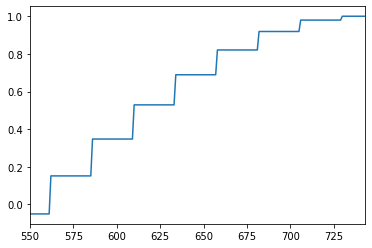

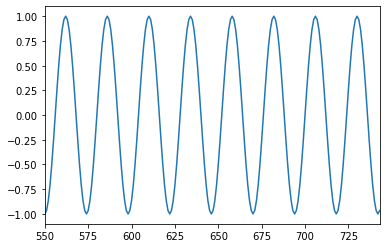

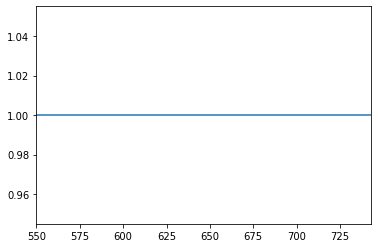

,pressão,umid,temp,dir_1,v_anemo2,ano,mês_cos,dia_cos,hora_cos
550,1014.845833,87.861111,21.516779,77.442821,12.242778,2015,1.0,-0.050649,-1.000000
551,1014.793333,73.338889,23.075269,73.171002,9.268333,2015,1.0,-0.050649,-0.965926
552,1014.085333,78.533333,22.545455,96.238878,8.734444,2015,1.0,-0.050649,-0.866025
553,1013.541500,83.722222,21.459770,110.156291,9.662222,2015,1.0,-0.050649,-0.707107
554,1013.563333,84.691275,22.133803,97.686662,8.620556,2015,1.0,-0.050649,-0.500000
...,...,...,...,...,...,...,...,...,...
739,1018.871167,90.612500,25.545455,88.967009,7.370556,2015,1.0,1.000000,-0.707107
740,1018.303667,91.142857,23.558442,89.474475,10.400556,2015,1.0,1.000000,-0.866025
741,1017.004667,90.567376,23.369863,89.119129,12.400556,2015,1.0,1.000000,-0.965926
742,1016.574167,88.645833,23.240741,85.945816,13.944444,2015,1.0,1.000000,-1.000000


In [8]:
X_test_data["mês_cos"] = np.cos(2 * np.pi * X_test_data["mês"] / 12)
X_test_data["dia_cos"] = np.cos(2 * np.pi * X_test_data["dia"] / 31)
X_test_data["hora_cos"] = np.cos(2 * np.pi * X_test_data["hora"] / 24)

X_test_data.drop("dia", axis=1, inplace=True)
X_test_data.drop("hora", axis=1, inplace=True)
X_test_data.drop("mês", axis=1, inplace=True)

X_test_data["dia_cos"].plot()
plt.show()
X_test_data["hora_cos"].plot()
plt.show()
X_test_data["mês_cos"].plot()
plt.show()
X_test_data

Preparando dados para previsão em intervalos de uma hora.

In [9]:
def prepare_data(X, number_of_hours):
    
    X = X.copy()

    Y = X.v_anemo2.shift(-number_of_hours)
    Y.drop(Y.tail(number_of_hours).index, inplace=True)
    X.drop(X.tail(number_of_hours).index, inplace=True)
    
    return X, Y

In [10]:
X_train, Y_train = prepare_data(X_train_data, 1)
X_test, Y_test = prepare_data(X_test_data, 1)

Realizando a normalização com `minmax`.

In [11]:
def scale(X):
    scaler = MinMaxScaler()
    return scaler.fit_transform(X.values)

X_train = scale(X_train)
X_test = scale(X_test)

## Treino

Realizando o processo de treino do modelo, incluindo dados de validação.

In [12]:
%%capture

lr_finder = LRFinder(model.model)
lr_finder.find(X_train, Y_train, start_lr=0.0001, end_lr=20.0, epochs=300)

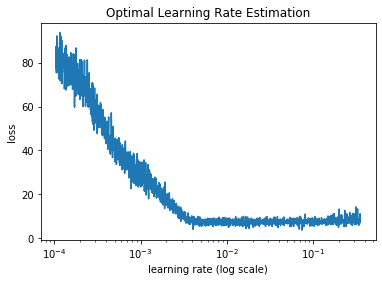

In [13]:
lr_finder.plot_loss()
plt.title(f"Optimal Learning Rate Estimation")
plt.show()

In [14]:
verbose = 0

training_history = model.train(
    X_train, Y_train.values, X_test, Y_test.values,
    epochs=50, verbose=verbose
)

## Avaliação

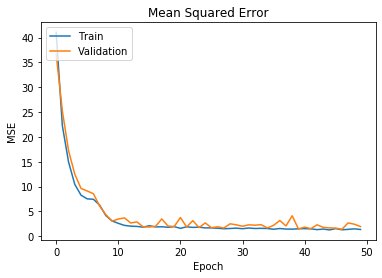

In [15]:
plt.plot(training_history.history["mse"])
plt.plot(training_history.history["val_mse"])
plt.title(f"Mean Squared Error")
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

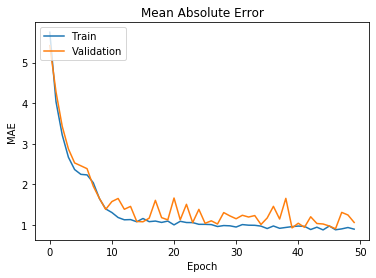

In [16]:
plt.plot(training_history.history["mae"])
plt.plot(training_history.history["val_mae"])
plt.title(f"Mean Absolute Error")
plt.ylabel("MAE")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [17]:
def predict(X, number_of_hours):
  
    assert number_of_hours > 0

    result = None
    input_data = X.copy()
    input_data_values = scale(input_data)
    
    for hour in range(number_of_hours):
        
        input_data_values = scale(input_data)
        predictions = [model.predict([[value]])[0][0] for value in input_data_values]
        input_data.drop(input_data.head(1).index, inplace=True)
        predictions = predictions[:-1]
        input_data.v_anemo2 = predictions
        result = predictions
        
    return result

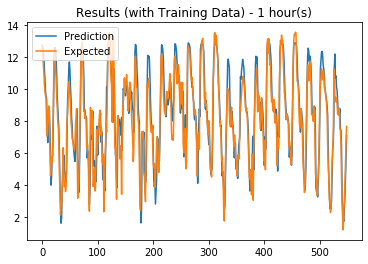

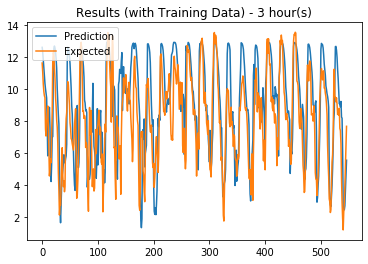

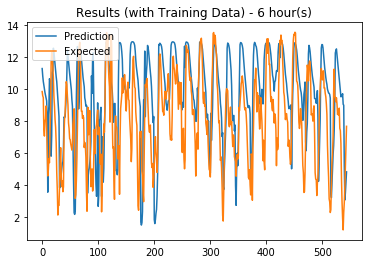

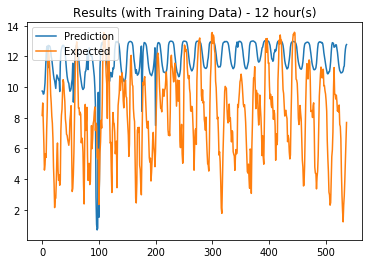

In [18]:
for hour in [1, 3, 6, 12]:
    prediction = predict(X_train_data, hour)
    _, expected_results = prepare_data(X_train_data, hour)
    
    if hour == 1:
        training_history.history["r_train"] = pearsonr(expected_results, prediction)
        training_history.history["r2_train"] = r2_score(expected_results, prediction)

    plt.plot(prediction)
    plt.plot(expected_results.values)
    plt.title(f"Results (with Training Data) - {hour} hour(s)")
    plt.legend(["Prediction", "Expected"], loc="upper left")
    plt.show()

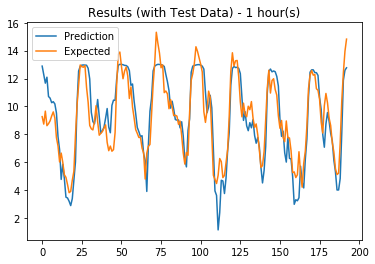

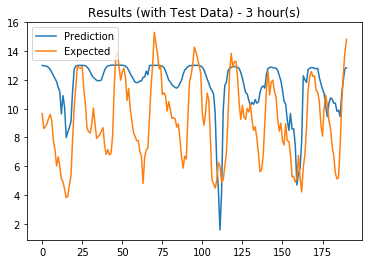

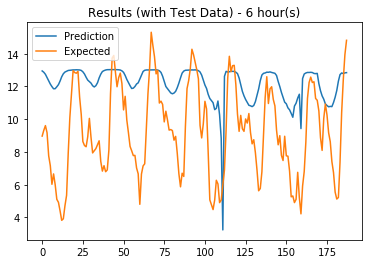

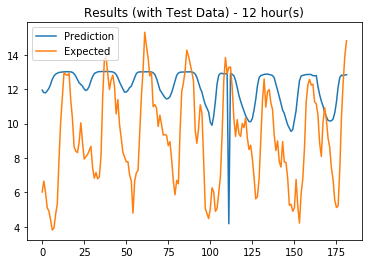

In [19]:
for hour in [1, 3, 6, 12]:
    prediction = predict(X_test_data, hour)
    _, expected_results = prepare_data(X_test_data, hour)
    
    if hour == 1:
        training_history.history["r_test"] = pearsonr(expected_results, prediction)
        training_history.history["r2_test"] = r2_score(expected_results, prediction)

    plt.plot(prediction)
    plt.plot(expected_results.values)
    plt.title(f"Results (with Test Data) - {hour} hour(s)")
    plt.legend(["Prediction", "Expected"], loc="upper left")
    plt.show()

In [20]:
table = [
    ["Metric",],
    ["MSE training",],
    ["MSE validation",],
    ["MAE training",],
    ["MAE validation",],
    ["R training",],
    ["R test",],
    ["R2 training",],
    ["R2 test",],
]
    
table[0].append("Value")
table[1].append(min(training_history.history['mse']))
table[2].append(min(training_history.history['val_mse']))
table[3].append(min(training_history.history['mae']))
table[4].append(min(training_history.history['val_mae']))
table[5].append(training_history.history['r_train'][0])
table[6].append(training_history.history['r_test'][0])
table[7].append(training_history.history['r2_train'])
table[8].append(training_history.history['r2_test'])
    
display(HTML(tabulate.tabulate(table, tablefmt="html", headers="firstrow")))

Metric,Value
MSE training,1.25384
MSE validation,1.38068
MAE training,0.877836
MAE validation,0.906503
R training,0.916574
R test,0.894405
R2 training,0.815091
R2 test,0.734021
